<a href="https://colab.research.google.com/github/peisuke/generative_ai_notebooks/blob/main/24_StableVideoDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Stability-AI/generative-models.git
!wget https://gist.githubusercontent.com/mkshing/4ad40699756d996ba6b3f7934e6ca532/raw/3f0094272c7a2bd3eb5f1a0db91bed582c9e8f01/requirements.txt
!pip3 install -r requirements.txt
!pip3 install -e generative-models
!pip3 install -e git+https://github.com/Stability-AI/datapipelines.git@main#egg=sdata

Cloning into 'generative-models'...
remote: Enumerating objects: 860, done.
remote: Counting objects: 100% (513/513), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 860 (delta 365), reused 306 (delta 263), pack-reused 347
Receiving objects: 100% (860/860), 42.67 MiB | 29.23 MiB/s, done.
Resolving deltas: 100% (436/436), done.
--2023-12-14 05:41:49--  https://gist.githubusercontent.com/mkshing/4ad40699756d996ba6b3f7934e6ca532/raw/3f0094272c7a2bd3eb5f1a0db91bed582c9e8f01/requirements.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 746 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     746  --.-KB/s    in 0s      

2023-12-14 05:41:49 (45.6 MB/s) - ‘requirements.txt’ saved [746/746]

Lo

Obtaining file:///content/generative-models
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sgm (pyproject.toml) ... done
  Created wheel for sgm: filename=sgm-0.1.0-py3-none-any.whl size=26918 sha256=57f3edb79301e69e286dcf17137d5023fb607592a4bb45344999ec0257d4851e
  Stored in directory: /tmp/pip-ephem-wheel-cache-5movm8sd/wheels/12/9b/27/03142f4dee9fa0a99f6c146eae81eb66e17b781145ecb05fa5
Successfully built sgm
Obtaining sdata from git+https://github.com/Stability-AI/datapipelines.git@main#egg=sdata
  Cloning https://github.com/Stability-AI/datapipelines.git (to revision main) to ./src/sdata
  Running command git clone --filter=blob:none --quiet https://github.com/Stability-AI/datapipelines.git /content/src/sdata
  Resolved https://github.com/Stability-AI/datapipelines.git to commit 8bce77d147033b3a5285b6

In [2]:
!mkdir -p /content/scripts/util/detection
!ln -s /content/generative-models/scripts/util/detection/p_head_v1.npz /content/scripts/util/detection/p_head_v1.npz
!ln -s /content/generative-models/scripts/util/detection/w_head_v1.npz /content/scripts/util/detection/w_head_v1.npz

In [3]:
!mkdir -p checkpoints
!wget https://huggingface.co/stabilityai/stable-video-diffusion-img2vid-xt/resolve/main/svd_xt.safetensors \
    -O checkpoints/svd_xt.safetensors

--2023-12-14 05:47:40--  https://huggingface.co/stabilityai/stable-video-diffusion-img2vid-xt/resolve/main/svd_xt.safetensors
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.37, 3.163.189.74, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/6e/59/6e594adc90884e0f59c5249f166a20166135ccab3a168d824ca8ef3bc5512e8c/b2652c23d64a1da5f14d55011b9b6dce55f2e72e395719f1cd1f8a079b00a451?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27svd_xt.safetensors%3B+filename%3D%22svd_xt.safetensors%22%3B&Expires=1702788253&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMjc4ODI1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzZlLzU5LzZlNTk0YWRjOTA4ODRlMGY1OWM1MjQ5ZjE2NmEyMDE2NjEzNWNjYWIzYTE2OGQ4MjRjYThlZjNiYzU1MTJlOGMvYjI2NTJjMjNkNjRhMWRhNWYxNGQ1NTAxMWI5YjZkY2U1NWYy

In [4]:
import sys
from omegaconf import OmegaConf

import torch

sys.path.append("generative-models")
from sgm.util import default, instantiate_from_config
from scripts.util.detection.nsfw_and_watermark_dectection import DeepFloydDataFiltering

def load_model(
    config: str,
    device: str,
    num_frames: int,
    num_steps: int,
):
    config = OmegaConf.load(config)
    config.model.params.conditioner_config.params.emb_models[
        0
    ].params.open_clip_embedding_config.params.init_device = device
    config.model.params.sampler_config.params.num_steps = num_steps
    config.model.params.sampler_config.params.guider_config.params.num_frames = (
        num_frames
    )
    with torch.device(device):
        model = instantiate_from_config(config.model).to(device).eval().requires_grad_(False)

    filter = DeepFloydDataFiltering(verbose=False, device=device)
    return model, filter

version = "svd_xt"

if version == "svd":
    num_frames = 14
    num_steps = 25
    # output_folder = default(output_folder, "outputs/simple_video_sample/svd/")
    model_config = "generative-models/scripts/sampling/configs/svd.yaml"
elif version == "svd_xt":
    num_frames = 25
    num_steps = 30
    # output_folder = default(output_folder, "outputs/simple_video_sample/svd_xt/")
    model_config = "generative-models/scripts/sampling/configs/svd_xt.yaml"
else:
    raise ValueError(f"Version {version} does not exist.")

device = "cuda" if torch.cuda.is_available() else "cpu"
model, filter = load_model(
    model_config,
    device,
    num_frames,
    num_steps,
)
# move models expect unet to cpu
model.conditioner.cpu()
model.first_stage_model.cpu()
# change the dtype of unet
model.model.to(dtype=torch.float16)
torch.cuda.empty_cache()
model = model.requires_grad_(False)

VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing


open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Initialized embedder #0: FrozenOpenCLIPImagePredictionEmbedder with 683800065 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: VideoPredictionEmbedderWithEncoder with 83653863 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
Restored from checkpoints/svd_xt.safetensors with 0 missing and 0 unexpected keys


100%|███████████████████████████████████████| 890M/890M [00:23<00:00, 40.1MiB/s]


In [5]:
!wget "https://user-images.githubusercontent.com/33302880/284758167-367a25d8-8d7b-42d3-8391-6d82813c7b0f.png" -O image.png

--2023-12-14 05:51:36--  https://user-images.githubusercontent.com/33302880/284758167-367a25d8-8d7b-42d3-8391-6d82813c7b0f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 737916 (721K) [image/png]
Saving to: ‘image.png’

image.png           100%[===================>] 720.62K  --.-KB/s    in 0.03s   

2023-12-14 05:51:37 (25.6 MB/s) - ‘image.png’ saved [737916/737916]



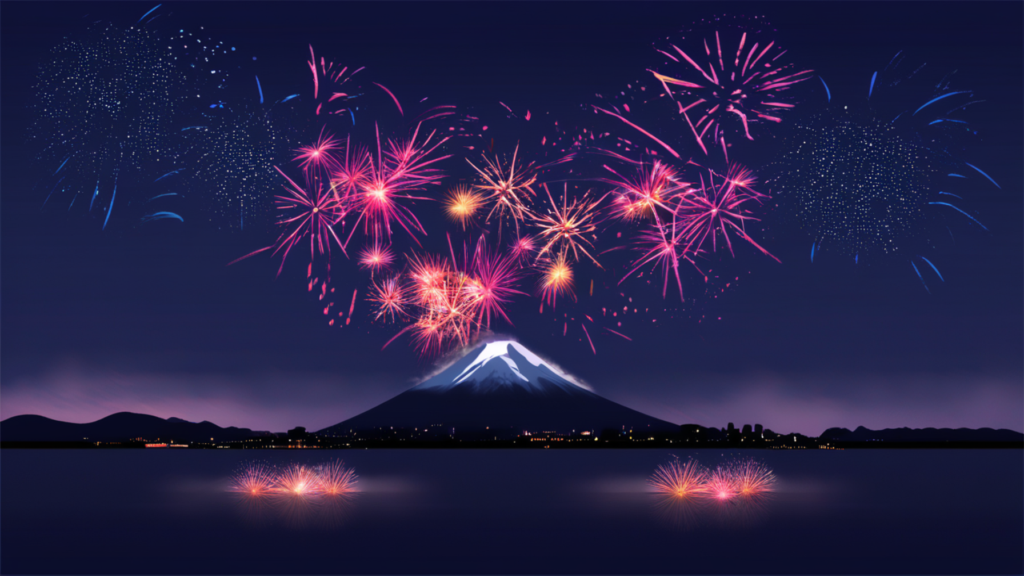

In [6]:
from PIL import Image
Image.open("image.png")

In [7]:
import math
import os
from glob import glob
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import torch
from einops import rearrange, repeat
from fire import Fire

from PIL import Image
from torchvision.transforms import ToTensor
from torchvision.transforms import functional as TF

from sgm.inference.helpers import embed_watermark
from sgm.util import default, instantiate_from_config

In [8]:
def get_unique_embedder_keys_from_conditioner(conditioner):
    return list(set([x.input_key for x in conditioner.embedders]))

In [9]:
def get_batch(keys, value_dict, N, T, device, dtype=None):
    batch = {}
    batch_uc = {}

    for key in keys:
        if key == "fps_id":
            batch[key] = (
                torch.tensor([value_dict["fps_id"]])
                .to(device, dtype=dtype)
                .repeat(int(math.prod(N)))
            )
        elif key == "motion_bucket_id":
            batch[key] = (
                torch.tensor([value_dict["motion_bucket_id"]])
                .to(device, dtype=dtype)
                .repeat(int(math.prod(N)))
            )
        elif key == "cond_aug":
            batch[key] = repeat(
                torch.tensor([value_dict["cond_aug"]]).to(device, dtype=dtype),
                "1 -> b",
                b=math.prod(N),
            )
        elif key == "cond_frames":
            batch[key] = repeat(value_dict["cond_frames"], "1 ... -> b ...", b=N[0])
        elif key == "cond_frames_without_noise":
            batch[key] = repeat(
                value_dict["cond_frames_without_noise"], "1 ... -> b ...", b=N[0]
            )
        else:
            batch[key] = value_dict[key]

    if T is not None:
        batch["num_video_frames"] = T

    for key in batch.keys():
        if key not in batch_uc and isinstance(batch[key], torch.Tensor):
            batch_uc[key] = torch.clone(batch[key])
    return batch, batch_uc

def sample(
    input_img_path: str = "assets/test_image.png",  # Can either be image file or folder with image files
    resize_image: bool = False,
    num_frames: Optional[int] = None,
    num_steps: Optional[int] = None,
    fps_id: int = 6,
    motion_bucket_id: int = 127,
    cond_aug: float = 0.02,
    seed: int = 23,
    decoding_t: int = 14,  # Number of frames decoded at a time! This eats most VRAM. Reduce if necessary.
    device: str = "cuda",
    output_folder: Optional[str] = "/content/outputs",
    skip_filter: bool = False,
):
    with Image.open(input_img_path) as image:
        if image.mode == "RGBA":
            image = image.convert("RGB")
        if resize_image and image.size != (1024, 576):
            print(f"Resizing {image.size} to (1024, 576)")
            image = TF.resize(TF.resize(image, 1024), (576, 1024))
        w, h = image.size

        if h % 64 != 0 or w % 64 != 0:
            width, height = map(lambda x: x - x % 64, (w, h))
            image = image.resize((width, height))
            print(
                f"WARNING: Your image is of size {h}x{w} which is not divisible by 64. We are resizing to {height}x{width}!"
            )

        image = ToTensor()(image)
        image = image * 2.0 - 1.0

    image = image.unsqueeze(0).to(device)
    H, W = image.shape[2:]
    assert image.shape[1] == 3
    F = 8
    C = 4
    shape = (num_frames, C, H // F, W // F)
    if (H, W) != (576, 1024):
        print(
            "WARNING: The conditioning frame you provided is not 576x1024. This leads to suboptimal performance as model was only trained on 576x1024. Consider increasing `cond_aug`."
        )
    if motion_bucket_id > 255:
        print(
            "WARNING: High motion bucket! This may lead to suboptimal performance."
        )

    if fps_id < 5:
        print("WARNING: Small fps value! This may lead to suboptimal performance.")

    if fps_id > 30:
        print("WARNING: Large fps value! This may lead to suboptimal performance.")

    value_dict = {}
    value_dict["motion_bucket_id"] = motion_bucket_id
    value_dict["fps_id"] = fps_id
    value_dict["cond_aug"] = cond_aug
    value_dict["cond_frames_without_noise"] = image
    value_dict["cond_frames"] = image + cond_aug * torch.randn_like(image)
    value_dict["cond_aug"] = cond_aug

    # low vram mode
    model.conditioner.cpu()
    model.first_stage_model.cpu()
    torch.cuda.empty_cache()
    model.sampler.verbose = True

    with torch.no_grad():
        with torch.autocast(device):
            model.conditioner.to(device)
            batch, batch_uc = get_batch(
                get_unique_embedder_keys_from_conditioner(model.conditioner),
                value_dict,
                [1, num_frames],
                T=num_frames,
                device=device,
            )
            c, uc = model.conditioner.get_unconditional_conditioning(
                batch,
                batch_uc=batch_uc,
                force_uc_zero_embeddings=[
                    "cond_frames",
                    "cond_frames_without_noise",
                ],
            )
            model.conditioner.cpu()
            torch.cuda.empty_cache()

            # from here, dtype is fp16
            for k in ["crossattn", "concat"]:
                uc[k] = repeat(uc[k], "b ... -> b t ...", t=num_frames)
                uc[k] = rearrange(uc[k], "b t ... -> (b t) ...", t=num_frames)
                c[k] = repeat(c[k], "b ... -> b t ...", t=num_frames)
                c[k] = rearrange(c[k], "b t ... -> (b t) ...", t=num_frames)
            for k in uc.keys():
                uc[k] = uc[k].to(dtype=torch.float16)
                c[k] = c[k].to(dtype=torch.float16)

            randn = torch.randn(shape, device=device, dtype=torch.float16)

            additional_model_inputs = {}
            additional_model_inputs["image_only_indicator"] = torch.zeros(
                2, num_frames
            ).to(device, )
            additional_model_inputs["num_video_frames"] = batch["num_video_frames"]

            for k in additional_model_inputs:
                if isinstance(additional_model_inputs[k], torch.Tensor):
                    additional_model_inputs[k] = additional_model_inputs[k].to(dtype=torch.float16)

            def denoiser(input, sigma, c):
                return model.denoiser(
                    model.model, input, sigma, c, **additional_model_inputs
                )

            samples_z = model.sampler(denoiser, randn, cond=c, uc=uc)
            samples_z.to(dtype=model.first_stage_model.dtype)
            ##

            model.en_and_decode_n_samples_a_time = decoding_t
            model.first_stage_model.to(device)
            samples_x = model.decode_first_stage(samples_z)
            samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)
            model.first_stage_model.cpu()
            torch.cuda.empty_cache()

            os.makedirs(output_folder, exist_ok=True)
            base_count = len(glob(os.path.join(output_folder, "*.mp4")))
            video_path = os.path.join(output_folder, f"{base_count:06d}.mp4")
            writer = cv2.VideoWriter(
                video_path,
                cv2.VideoWriter_fourcc(*"MP4V"),
                fps_id + 1,
                (samples.shape[-1], samples.shape[-2]),
            )

            samples = embed_watermark(samples)
            if not skip_filter:
                samples = filter(samples)
            else:
                print("WARNING: You have disabled the NSFW/Watermark filter. Please do not expose unfiltered results in services or applications open to the public.")
            vid = (
                (rearrange(samples, "t c h w -> t h w c") * 255)
                .cpu()
                .numpy()
                .astype(np.uint8)
            )
            for frame in vid:
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                writer.write(frame)
            writer.release()
    return video_path

In [10]:
video_path = sample(
    input_img_path="image.png",
    resize_image=True,
    num_frames=25,
    num_steps=30,
    fps_id=6,
    motion_bucket_id=127,
    cond_aug=0.02,
    seed=42,
    decoding_t=2,  # Number of frames decoded at a time! This eats most VRAM. Reduce if necessary.
    device=device,
    skip_filter=False,
)

##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: EDMDiscretization
Guider: LinearPredictionGuider


Sampling with EulerEDMSampler for 31 steps:   0%|          | 0/31 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Sampling with EulerEDMSampler for 31 steps:  97%|█████████▋| 30/31 [07:07<00:14, 14.24s/it]


In [11]:
from IPython.display import HTML
import base64
import io

video = io.open(video_path, 'rb').read()
encoded = base64.b64encode(video)
video_ascii = encoded.decode('ascii')
HTML(data=f"""<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_ascii}" type="video/mp4" /></video>""")